# Link Prediction
In this notebook, we perform linkperdiction and compare obtained result for both $D_{sas}$ and $D_{obs}$ dataset. We will generate noble features using metadata information and perform *LSTM* based timeseries forecasting and link classification using those features.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
import pickle
import PathSim as ps
import importlib

Using Theano backend.


In [2]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [3]:
#word_vectors = KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

#### Path for dataset and other files.

In [4]:
#########dataset and domain selection : sleep apnea: 0 ; obesity:1
importlib.reload(ut)
select_domain  = 0
domain = ['apnea','obesity']
root = '../linkPrediction/'
filepath=[['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv'],
        ['dataset/obesity-all,3.csv',
         'dataset/obesity-distinct_keyword.csv']]
########path to save graph files
graphpath=root+'graphs/'+domain[select_domain]
########path to save result files, data files and resultent figures
datapath=root+'dataframes/'+domain[select_domain]
#path to save classification models
modelpath=root+'models/'+domain[select_domain]
########columns with sub-columns
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_year, train:start_year, test:start_year, no_of_test_years(1), total_year_in_each_iteration, no of grandparents]
time=[2007,2008,2015,1,1,20]
######load dataset and keyword list into dataframes
df, key_list = ut.load_dataset(filepath[select_domain], column_split)

#### print a file path

In [5]:
graphpath

'../linkPrediction/graphs/apnea'

#### graph building and saving in graphpath

In [ ]:
#######graph building and saving in graphpath: train graph, test graph and parent graph(previous year of train graph)  
importlib.reload(gr)
time=[2007,2008,2015,1,1,20]
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

#### Load all graphs into dictionary of networkx graphs

In [247]:
# time=[1991,1992,1994,1,1,20]
importlib.reload(gr)
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)
# g_train, g_test = gr.graph_norm(root, domain, select_domain, g_train, g_test)

../linkPrediction/graphs/apnea\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle loaded, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle loaded, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle loaded, nodes: 1093 edges: 2019


#### Delete search keys

In [248]:
s_key={0:[9875,1020],1:[7614,9953]}
for t in range(2008,2015):
    g_train[t].remove_nodes_from(s_key[select_domain])
g_test[2015].remove_nodes_from(s_key[select_domain])
g_parent.remove_nodes_from(s_key[select_domain])
g_train_static.remove_nodes_from(s_key[select_domain])
g_test_static.remove_nodes_from(s_key[select_domain])

In [9]:
importlib.reload(gr)
assoc=0
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)
g_train, g_test = gr.graph_norm(root, domain, select_domain, g_train, g_test,0.0001)

../linkPrediction/graphs/apnea\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle loaded, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle loaded, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/Informetrics/

In [18]:
def get_lists(g):    
    node_article = []
    art_author = []
    node_list=[]
    aut_list=[]
    art_list=[]
    for nd, row in g.nodes(data=True):
        node_list.append(nd)
        for art_s in row['art_id']:
            art_list.append(art_s)
            node_article.append((nd,art_s))
    for art_s in art_list:
        a = df.loc[df['art_id']==art_s,['art_year','author_name']]
        aa = a['author_name'].values[0]
        a = list(itertools.product([art_s], aa))
        art_author.extend(a)
        aut_list.extend(aa)
    node_list=list(set(node_list))
    aut_list=list(set(aut_list))
    art_list=list(set(art_list))
    return node_list, aut_list, art_list, node_article, art_author

In [20]:
importlib.reload(ps)

def creat_adj(node_list, aut_list, art_list, node_article, art_author):
    #  Create the node-aut adjacency

    node_art_df = pd.DataFrame(node_article, columns=['node', 'article'])
    node_art_adj = pd.DataFrame(0, index=node_list, columns=art_list)
    for nd, art in zip(node_art_df['node'], node_art_df['article']):
        node_art_adj.at[nd, art]=1
    node_art_adj = node_art_adj.dropna(axis='columns')

    # #  Create the aut-art adjacency
    #
    art_aut_df = pd.DataFrame(art_author, columns=['article','author'])
    art_aut_adj = pd.DataFrame(0, index=art_list, columns=aut_list)
    for art, aut in zip(art_aut_df['article'], art_aut_df['author']):
        art_aut_adj.at[art, aut]=1
    art_aut_adj = art_aut_adj.dropna(axis='columns')
    return node_art_adj,art_aut_adj

In [28]:
importlib.reload(ps)
for t in range(2008,2009):
    if t==2015:
        g=g_test[t]
    else:
        g=g_train[t]
    node_list, aut_list, art_list, node_article, art_author = get_lists(g)
    mult = lambda x: np.asarray(x) * np.asarray(s)
    node_art_adj,art_aut_adj=creat_adj(node_list, aut_list, art_list, node_article, art_author)
    result = ps.commute_matrix(node_art_adj, art_aut_adj, 6138)
    AD, s = ps.scaling(result, 6138)
    an_hai = AD.apply(mult)
    an_hai_result = an_hai.sort_values('pathsim_score', ascending=False)

In [249]:
importlib.reload(ut)
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
test_data = ut.load_data(datapath, domain[select_domain], "test_data", time)
test_node = ut.load_data(datapath, domain[select_domain], "test_node", time)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge_list length:',len(edge_list))
print('test_data length:',len(test_data[2015]))
print('test_node length:',len(test_node[2015]))

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
train data length: 7
node feature length: 7
edge_list length: 12494
test_data length: 12494
test_node length: 1093


In [41]:
from collections import Iterable


def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [140]:
importlib.reload(ps)

t=2007
g=g_parent
node_feature[t]={}
nodes = list(g_parent.nodes())
node_feature[t]= pd.DataFrame({'node_index': nodes})
node_feature[t]['arts']=node_feature[t].apply(lambda row: list(g.nodes[row['node_index']]['art_id']) ,axis=1)
arts = list(node_feature[t]['arts'])
arts = set(flatten(arts))
dd = df[df['art_id'].isin(arts)]['citation']
print(t, dd.sum(),dd.count(),dd.sum()/dd.count())

for t in range(2008,2015):
    if t==2015:
        g=g_test[t]
    else:
        g=g_train[t]
    node_feature[t]['arts']=node_feature[t].apply(lambda row: list(g.nodes[row['node_index']]['art_id']) ,axis=1)
    arts = list(node_feature[t]['arts'])
    arts = set(flatten(arts))
    dd = df[df['art_id'].isin(arts)]['citation']
    print(t, dd.sum(),dd.count(),dd.sum()/dd.count())

t=2015
g=g_test[t]
node_feature[t]=test_node[2015]
node_feature[t]['arts']=node_feature[t].apply(lambda row: list(g.nodes[row['node_index']]['art_id']) ,axis=1)
arts = list(node_feature[t]['arts'])
arts = set(flatten(arts))
dd = df[df['art_id'].isin(arts)]['citation']
print(t, dd.sum(),dd.count(),dd.sum()/dd.count())

2007 113300 4418 25.645088275237665
2008 93371 4625 20.188324324324324
2009 80609 5067 15.908624432603117
2010 64785 5943 10.901060070671377
2011 48419 7198 6.726729647124201
2012 30374 8750 3.4713142857142856
2013 7577 8595 0.8815590459569517
2014 46361 6668 6.952759448110378
2015 20342 6907 2.9451281308817143


In [250]:

col_types = {'node_type_aut':'author','node_type_art':'article','node_type_deg':'keyword'}
tps ={5:'parent',25:'grandparent'}
for key, val in col_types.items():
    node_types={}
    for t in range(2008,2015):
        nf = node_feature[t]
        gp = nf.loc[(nf[key]>4),['node_index',key]]
        dt =pd.DataFrame()
        dt = gp
        dt['label']=dt.apply(lambda row: gr.node_label_find(key_list,row['node_index']),axis=1)
        dt['type']=dt.apply(lambda row: tps[row[key]],axis=1)
        del dt[key]
        node_types[t]=dt
    ut.save_data(node_types, datapath, domain[select_domain], val+"-node-types", time)

../linkPrediction/dataframes/apnea\apnea-author-node-types_2008-2015.pkl
../linkPrediction/dataframes/apnea\apnea-article-node-types_2008-2015.pkl
../linkPrediction/dataframes/apnea\apnea-keyword-node-types_2008-2015.pkl


In [ ]:
importlib.reload(fs)
importlib.reload(cl)
#ration of negative:positive train instance:(eg,10 for 10:1=neg:pos)
freq=10
#time=[2001,2007,2015,1,1,10]
#train_data building: dictionary of each years non-connected node pairs dataframes
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
#train_data: non-connected node pairs with feature values
#node_features: node feature values
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

In [ ]:
article_set = []
node_set = []
y_weight = []
closeness = []
author_set = []
for nd, row in g_train[2014].node(data=True):
    node_set.append(nd)
    for art_s in row['art_id']:
        article_set.append(art_s)
    for author_s in row['author']:
        author_set.append(author_s)
article_set = set(article_set)
author_set = set(author_set)
article_index = list(article_set)
author_index = list(author_set)
node_index = list(node_set)

In [ ]:
node_article_list=[]
node_author_list=[]
a=0
for t in range(2008,2015,1):
    edge_list = list(g_train[t].edges())
    for nd, art in g_train[t].node(data='art_id'):
        for art_s in art:
            node_article_list.append((nd,art_s))
    for nd, aut in g_train[t].node(data='author'): 
        for aut_s in aut:
            node_author_list.append((nd,authors[aut_s]))
    rows = list(train_data[t]['row_name'])
    labels = list(train_data[t]['label'])
    nodepairs_label = merge(rows, labels)

    save(node_article_list,"node_article_list",t)
    save(node_author_list,"node_author_list",t)
    save(edge_list,'edge_list',t)
    save(nodepairs_label,"nodepairs_label_list",t)

t=2007
edge_list = list(g_parent.edges())
for nd, art in g_parent.node(data='art_id'):
    for art_s in art:
        node_article_list.append((nd,art_s))
for nd, aut in g_parent.node(data='author'):
    for aut_s in aut:
        node_author_list.append((nd,authors[aut_s]))
save(node_article_list,"node_article_list",t)
save(node_author_list,"node_author_list",t)
save(edge_list,'edge_list',t)

t=2015
edge_list = list(g_test[t].edges())
for nd, art in g_test[t].node(data='art_id'):
    for art_s in art:
        node_article_list.append((nd,art_s))
for nd, aut in g_test[t].node(data='author'):
    for aut_s in aut:
        node_author_list.append((nd,authors[aut_s]))
save(node_article_list,"node_article_list",t)
save(node_author_list,"node_author_list",t)
save(edge_list,'edge_list',t)
save(authors,'authors-id',20072015)

In [23]:
def load(name,t):
    filename = name + "_" + str(t) + ".pkl"
    data_path=root+'dataframes/exported lists/'+domain[select_domain]
    filename_path = os.path.join(data_path, filename)
    with open(filename_path, "rb") as f:
        data = pickle.load(f)
        print(filename_path)
    return data

In [26]:
authors = load('authors-id',20072015)
len(authors)

../linkPrediction/dataframes/exported lists/obesity\authors-id_20072015.pkl


210023

In [27]:
df

,art_id,keyword,art_year,citation,title,author_name,affiliation_1,affiliation_2,country
0,126202,"[adiponectin, hypertension, hypertriglyceridem...",2007,7,Plasma adiponectin T94G gene polymorphism and ...,[jeng j-r],[department of internal medicine tzuchi unive...,NaN,[taiwan]
1,126203,"[body weight, sexual abuse, women]",2007,20,Association of childhood sexual abuse with obe...,"[hughes tl, aaron dj]",[institute for health research and policy univ...,"[il, pa]",[united states]
2,126207,"[ileostomy, swine, urinary diversion]",2007,3,Modified Ileal Conduit Stoma Safety of Freeing...,"[abdallah mm, bissada nk]",[menoufia university little rock],[ar],[united states]
3,126208,"[dexmedetomidine, sedation]",2007,43,Dexmedetomidine as sole sedative for awake int...,"[hoban j, doyle dj, abdelmalak b, makary l]","[cleveland clinic cleveland, department of ge...",[oh],[united states]
4,126209,"[inflammation, leptin, obesity, sex difference]",2007,31,Sex differences in the association between lep...,"[abdullah sm, khera a, leonard d, das sr, canh...",[department of internal medicine the universi...,[tx],[united states]
...,...,...,...,...,...,...,...,...,...
64705,33455,"[dyspnea, elderly]",2013,0,Clinical profile of acute myocardial infarctio...,"[Naik RH, Bhatia LC]",[Department of Medicine Government Medical Co...,"[Gujarat, Haryana]",[India]
64706,33457,"[asian indian, nonalcoholic fatty liver disease]",2013,8,Association of peroxisome proliferator activat...,"[Luthra K, Bhatt SP, Pandey RM, Guleria R, Pas...",[ Institute of Genomics and Integrative Biolog...,"[Delhi, New Delhi]",[India]
64707,33459,"[fat accumulation, glucose uptake, kaempferol,...",2013,0,Bioactive components from flowers of Sambucus ...,"[Olsen LCB, Frgeman NJ, Kristiansen K, Christe...",[department of Biochemistry and Molecular Biol...,"[Aarslev, Copenhagen, Odense M, Tjele]",[Denmark]
64708,33461,"[anthropometric indicator, cardiometabolic ris...",2013,0,Anthropometric indicators of obesity for ident...,"[Bhowmik B, Hussain A, Diep LM, Habib SH, Sidd...","[ Diabetic Association of Bangladesh, Oslo...","[, Dhaka, Oslo]","[Bangladesh, Norway]"


In [ ]:
def merge(list1, list2): 
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
    return merged_list 

def save(data,name,t):
    filename = name + "_" + str(t) + ".pkl"
    data_path=root+'dataframes/exported lists/'+domain[select_domain]
    filename_path = os.path.join(data_path, filename)
    with open(filename_path, "wb") as f:
        pickle.dump(data, f)
        print(filename_path)

def load(name,t):
    filename = name + "_" + str(t) + ".pkl"
    data_path=root+'dataframes/exported lists/'+domain[select_domain]
    filename_path = os.path.join(data_path, filename)
    with open(filename_path, "rb") as f:
        data = pickle.load(f)
        print(filename_path)
    return data


a=0
authors = {}
for nd, aut in g_train_static.node(data='author'):
    for aut_s in aut:
        if aut_s not in authors.keys():
            authors[aut_s]='a-'+str(a)
            a=a+1  
t=2007
for nd, aut in g_parent.node(data='author'):
    for aut_s in aut:
        if aut_s not in authors.keys():
            authors[aut_s]='a-'+str(a)
            a=a+1 
            
t=2015
for nd, aut in g_test[t].node(data='author'):
    for aut_s in aut:
        if aut_s not in authors.keys():
            authors[aut_s]='a-'+str(a)
            a=a+1

#### Node level and edge level feature generation 

In [20]:
importlib.reload(fs)
importlib.reload(cl)
#ration of negative:positive train instance:(eg,10 for 10:1=neg:pos)
freq=10
##### time=[2001,2007,2015,1,1,10]
##### train_data building: dictionary of each years non-connected node pairs dataframes
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
#### train_data: non-connected node pairs with feature values
####node_features: node feature values
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos
test_size: 13055
neg
test_size: 8074547
pos in time series: 12743 neg in time series: 118263 pos-neg ratio: 0.10775136771433162 total: 131006


#### Save train_data and node_feature into filepath
filepath: path to save result files, data files and resultent figures

In [21]:
importlib.reload(ut)
ut.save_data(train_data, datapath, domain[select_domain], "train_data", time)
ut.save_data(node_feature, datapath, domain[select_domain], "node_feature", time)
ut.save_data(edge_list, datapath, domain[select_domain], "edge_list", time)

../linkPrediction/dataframes/obesity\obesity-train_data_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-node_feature_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-edge_list_2008-2015.pkl


#### Test data generation

In [22]:
importlib.reload(fs)
importlib.reload(cl)

edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
edge_set = set(edge_list)
edges = list(g_test[2015].edges())
non_edges =  list(nx.non_edges(g_test[2015]))
r_edges = [(b, a) for a, b in edges]
r_non_edges = [(b, a) for a, b in non_edges]
test_edges = []
label = []
train_ed=[]
ins = set(edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([1]*len(ins))
ins = set(r_edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([1]*len(ins))
ins = set(non_edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([0]*len(ins))
ins = set(r_non_edges).intersection(edge_set)
train_ed.extend(ins)
label.extend([0]*len(ins))
train_data={}
train_data[2015] = pd.DataFrame({'row_name': train_ed, 'label': label})

g_train[2015]=g_test[2015]
time=[2014,2015,2016,1,1,20]
test_node, test_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_train[2014], g_train, g_train_static, time)

../linkPrediction/dataframes/obesity


#### Save test_data and test_node into filepath
filepath: path to save result files, data files and resultent figures

In [23]:
importlib.reload(ut)
time=[2007,2008,2015,1,1,20]
ut.save_data(test_data, datapath, domain[select_domain], "test_data", time)
ut.save_data(test_node, datapath, domain[select_domain], "test_node", time)

../linkPrediction/dataframes/obesity\obesity-test_data_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-test_node_2008-2015.pkl


#### Print positive-negative training instance stats and other information

In [ ]:
#positive instance no
print(len(train_data_static[(train_data_static['label']==1)]))
#negative instance no
print(len(train_data_static[(train_data_static['label']==0)]))
#no of total nodes
print(len(g_train_static.nodes()))
#no of total train graph edges
print(len(g_train_static.edges()))
#no of total test graph edges
print(len(g_test_static.edges()))

#### Extract node_feature and train_data from saved files

In [32]:
importlib.reload(ut)
time=[2007,2008,2015,1,1,20]
train_data = ut.load_data(datapath, domain[select_domain], "train_data", time)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", time)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", time)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge list length:',len(edge_list))

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
train data length: 7
node feature length: 7
edge list length: 12494


#### Print sample data

In [ ]:
train_data[2015]

### Model training
1. Defining list of features
2. Data reshaping to feed into *LSTM* network
3. Test-train split
4. Normalized and reshaped data $(X,y)$ saving
5. Model training: forecasting and link classification
6. Saving model file
7. Evaluating model on test dataset
8. Result saving

In [ ]:
#model training-------feature list creation->data reshape->test-train split->training->model save->evaluating->result save
importlib.reload(fs)
importlib.reload(cl)
#training start year
ts = time[1]
#####training end year+1/ test year
te = time[2]

row = train_data[ts].columns.values.tolist()
######feature column names
feature_names = row[2:len(row)]
#####all possible combinations of features: will be used in case of multiple feature combination
all_combinations = itertools.chain(*[itertools.combinations(feature_names, i + 1)
                                     for i, _ in enumerate(feature_names)])
feature_list = list(all_combinations)
#######single feature based model building for each feature in the set of selective_features [our experiment]
#selective_features =  set(['typeaut','typeart','typenode','y_weight1','res_aloc','cm','close','pref','citation'])
selective_features =  set(['pref','citation'])
#domain_info(eg. obesity-2008-2015)
domain_info =  domain[select_domain]+"-"+str(ts)+"-"+str(te)+"-"
models  = []
results = []
#number of epochs and batch size in each epoch
con = [20,64]
batch_size = con[1]
for feature in feature_list:
    #drop feature columns for features which are not in the feature combination
    columns_drop = list(set(feature_names).difference(set(feature)))
    #only using single features from the set of selectiv_features. so feature length=1
    if len(feature)==1 and feature[0] in selective_features:
        #model name (eg. obesity-2008-2015-citation)
        model_name = '+'.join(feature)
        model_name = domain_info+model_name
        #copy train data with droping unnecessary feature columns
        pruned_data = copy.deepcopy(train_data)
        pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
        #data reshape for classification model (data_len_dm=[input sample length, input dimension, output dimension])
        X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)
        #training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
        #append result [feature name, loss, acc,auc,fpr,tpr,precision,recall] into result list
        results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
        #model save in path to save classification models
        model_file_path = os.path.join(modelpath, model_name + ".h5")
        model.save(model_file_path)
        models.append(model_name)
        print(model_file_path)
        #Reshaped X data save
        data_file_path = os.path.join(datapath,model_name+"-X"+".pkl")
        with open(data_file_path,"wb") as f:
            pickle.dump(X,f)
        print(data_file_path)
        #y data save
        data_file_path = os.path.join(datapath,model_name+"-y"+".pkl")
        with open(data_file_path,"wb") as f:
            pickle.dump(y,f)
        print(data_file_path)
#save result
ut.save_data(results, datapath, domain[select_domain], "results", time)

#### Printing AUC values from result dictionary

In [ ]:
for row in results:
    print(row['model name'], row['auc'])

### Model training from loaded $(X,y)$ data
1. Defining list of features
2. Loading $(X,y)$ data from disk
3. Test-train split
5. Model training: forecasting and link classification
6. Saving model file
7. Evaluating model on test dataset
8. Result saving

In [ ]:
######training from loaded data [same as upper one but, X and y data are loaded from file here]
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(ut)

ts = time[1]
te = time[2]
models  = []
results = []
con = [20,64]
batch_size = con[1]
#selective_features =  set(['typeaut','typeart','typenode','y_weight1','res_aloc','cm','close','pref'])
selective_features =  set(['y_weight1','pref','citation','typeaut','y_weight1','cm','res_aloc','close'])
domain_info =  domain[select_domain]+"-"+str(ts)+"-"+str(te)+"-"
for feature in selective_features:
    model_name = domain_info+feature
    X_file_path = os.path.join(datapath,model_name+"-X"+".pkl")
    with open(X_file_path,"rb") as f:
        X = pickle.load(f)
    y_file_path = os.path.join(datapath,model_name+"-y"+".pkl")
    with open(y_file_path,"rb") as f:
        y = pickle.load(f)
    #data shape
    input_length = X.shape[1]
    input_dim = X.shape[2]
    if len(y.shape) == 1:
        output_dim = 1
    else:
        output_dim = len(y[0])
    data_len_dm = [input_length, input_dim, output_dim]
    ####training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)
    model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
    results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
    ####model save
    model_file_path = os.path.join(modelpath, model_name + ".h5")
    model.save(model_file_path)
    models.append(model_name)
    print(model_file_path)
#save result
ut.save_data(results, datapath, domain[select_domain], "results", time)

#### Load result dictionary for both $D_{sas}$ and $D_{obs}$ dataset

In [7]:
#############load results
importlib.reload(ut)
####apnea result
resultpath=root+'dataframes/'+domain[0]
results_apnea = ut.load_data(resultpath, domain[0], "results", time)
####obesity result
resultpath=root+'dataframes/'+domain[1]
results_obesity = ut.load_data(resultpath, domain[1], "results", time)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/obesity


#### Sample result printing

In [ ]:
print(results_apnea[0]['model name'],results_apnea[0]['auc'],results_apnea[1]['auc'])
print(results_obesity[0]['model name'],results_obesity[0]['auc'],results_obesity[1]['auc'])

#### Generate and save figure comparing *AUC* values for all features and both datasets 

IndexError: list index out of range

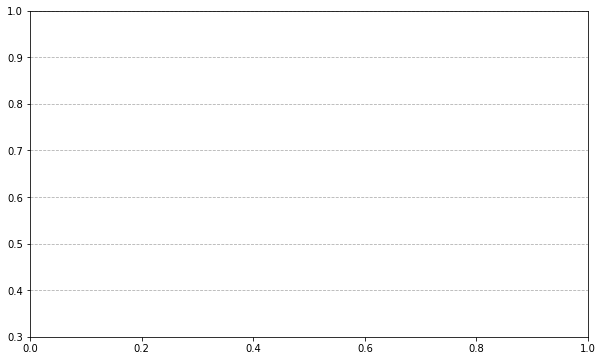

In [9]:
#######print and save auc figure
names = {'typeaut':'T-Aut','typeart':'T-Art','typenode':'T-Key','y_weight1':'T-Key-y',
         'res_aloc':'RA','cm':'CM','close':'CC','pref':'PA','citation':'Cite'}
colors = ['g','r','c','m','y','k','C0','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
xtick=[]
fig, ax = plt.subplots(figsize=(10,6)) 
#fig = plt.figure(figsize=(10,6))
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
plt.ylim(.3, 1)
bar_width = 0.35
result_lat = {'apnea':{},'obesity':{}}
for i in range(len(results_apnea)):
    name = results_apnea[i]['model name'].split('-')[3]
    result_lat['apnea'][names[name]]=results_apnea[i]['auc']
    result_lat['obesity'][names[name]]=results_obesity[i]['auc']
    ax.bar(i,results_obesity[i]['auc'] ,bar_width,align='center',alpha=0.8,color = colors[i])
    ax.text(i, .5,r'$D_{obs}$', color='k',horizontalalignment='center',rotation=90)
    ax.bar(i+bar_width+.06,results_apnea[i]['auc'] ,bar_width,align='center', alpha=0.4,color = colors[i])
    ax.text(i+bar_width+.06, .5, r'$D_{sas}$', color='k',horizontalalignment='center',rotation=90)
    xtick.append(names[name])
x_pos = np.arange(len(xtick))
plt.xticks(x_pos+.2, xtick, rotation=0)
plt.xlabel('Feature name', fontsize=12)
plt.ylabel('AUC', fontsize=12)
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'auc'+ ".png")
plt.savefig(fig_file_name)
###show
plt.show()

#### Generate and save *PR* & *ROC* curves for both datasets and all features

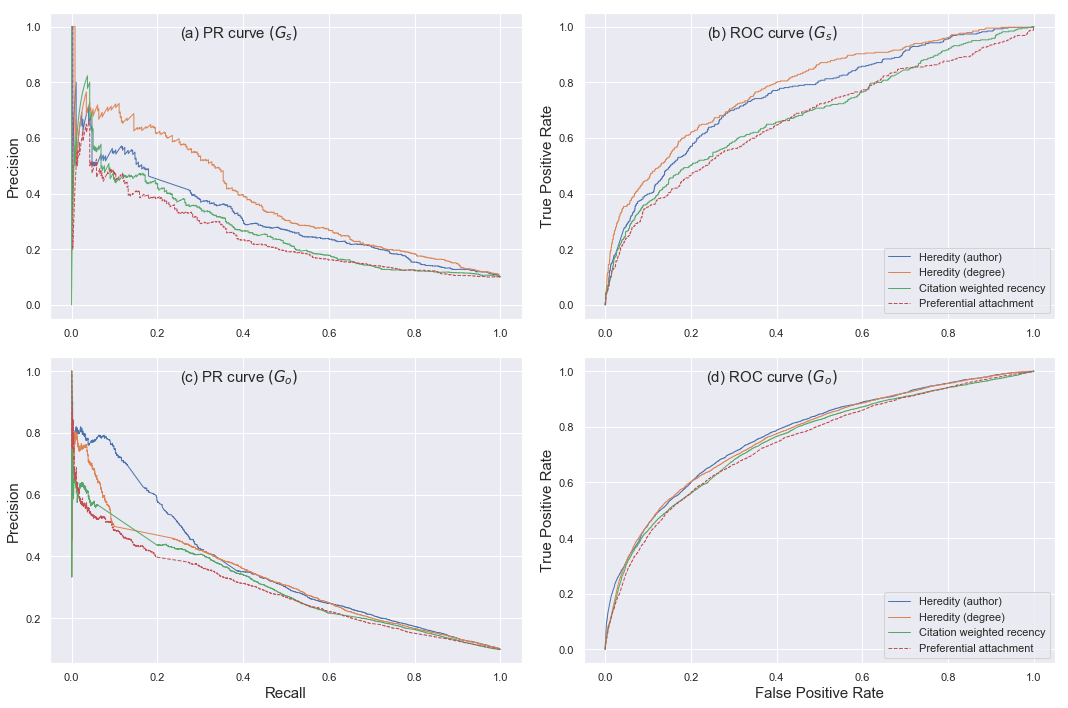

In [12]:
import seaborn as sns; sns.set(color_codes=True)
names = {'author':'Heredity (author)','article':'Heredity (article)','degree':'Heredity (degree)','y_weight1':'T-Key-y',
         'res_aloc':'RA','cm':'Common neighbour','close':'CC','pref':'Preferential attachment',
         'citation':'Citation weighted recency'}
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
for i,row in enumerate(results_apnea):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['recall'],row['precision'],'--', linewidth=1,label = names[name])
    elif i==3 or i==0 or i==2:
        plt.plot(row['recall'],row['precision'],'-', linewidth=1,label = names[name])
# plt.legend(loc='best',fancybox=True)
plt.title("(a) PR curve $(G_{s})$", position=(0.4, 0.9),fontsize=15)
# plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=15)
plt.tight_layout()
plt.subplot(2,2,2)
for i,row in enumerate(results_apnea):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,label = names[name])
    elif i==0 or i==3 or i==2:
        plt.plot(row['false positive'],row['true positive'],'-',linewidth=1,label = names[name])
plt.legend(loc='lower right')
plt.title("(b) ROC curve $(G_{s})$", position=(0.4, 0.9),fontsize=15)
# plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=15)
plt.tight_layout()

plt.subplot(2,2,3)
for i,row in enumerate(results_obesity):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['recall'],row['precision'],'--',linewidth=1,label = names[name])
    elif i==3 or i==0 or i==2:
        plt.plot(row['recall'],row['precision'],'-',linewidth=1,label = names[name])
# plt.legend(loc='best')
plt.title("(c) PR curve $(G_{o})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.tight_layout()
plt.subplot(2,2,4)
for i,row in enumerate(results_obesity):
#     if i==1 or i==2 or i==5 or i==7:
    name = row['model name']
    if i==4:
        plt.plot(row['false positive'],row['true positive'],'--',linewidth=1,label = names[name])
    elif i==3 or i==0 or i==2:
        plt.plot(row['false positive'],row['true positive'],'-',linewidth=1,label = names[name])
plt.legend(loc='lower right')
plt.title("(d) ROC curve $(G_{o})$", position=(0.4, 0.9),fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'pr-roc-100'+ ".pdf")
plt.savefig(fig_file_name)
#show
plt.show()

#### Generate *LATEX* table containing *AUC* values for both dataset-features

In [ ]:
result_lat
result_df = pd.DataFrame(result_lat)
#####generate latex table of auc values
print(result_df.to_latex(float_format=lambda x: '%.2f' % x))

#### Gephi graph formated (gexf) graph generate and save

In [ ]:
ts = time[1]
te = time[2]
label = dict(zip(key_list['id'], key_list['keyword']))
for t in range(ts,te):
    gephy_g = nx.Graph()
    nodes = list(g_train[t].nodes())
    edges = list(g_train[t].edges())
    gephy_g.add_nodes_from(nodes,year=t)
    gephy_g.add_edges_from(edges,year=t)
    aut = dict(zip(node_feature[t]['node_index'], node_feature[t]['term_aut']))
    types = dict(zBBip(node_feature[t]['node_index'], node_feature[t]['node_type_aut']))
    nx.set_node_attributes(gephy_g, aut, 'aut')
    nx.set_node_attributes(gephy_g, label, 'label')
    nx.set_node_attributes(gephy_g, types, 'types')
    file = "gephy\g-obesity-"+str(t)+".gexf"
    nx.write_gexf(gephy_g, file)